# Vectorized Backtesting Tutorial
*By: Jacques Francois Joubert*

This Jupyter Notebook provides a tutorial on conducting a vectorized backtest using a simple moving average crossover strategy on the S&P 500 Index (SPX) close price data. We'll use data from Yahoo Finance and leverage QuantStats for performance analysis.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs

import matplotlib.pyplot as plt

#### Trouble?
If you need help to install the dependencies, then open the markdown file: getting_started.md

---
## Fetching SPX Adj Close Price Data from Yahoo Finance
To access historical data for the S&P 500 Index (^GSPC), we will use the yfinance library, a powerful tool for downloading financial data from Yahoo Finance.

##### Steps for Data Retrieval:
1. **Specify the Ticker Symbol**: The S&P 500 Index is represented by the ticker symbol ^GSPC.
2. **Define the Time Period**: We set the start date to '1991-01-01' and the end date to '2023-01-01' to retrieve data over this period.
3. **Fetch the Data**: We use yf.download() to download the data and extract the Close prices.

In [2]:
# Downloading S&P 500 index data from Yahoo Finance
spx = yf.download('^GSPC', start='1991-01-01', end='2023-01-01')

# Extracting the closing prices
close_prices = spx['Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
close_prices.tail()

Date
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
2022-12-30    3839.500000
Name: Close, dtype: float64

##### Visualizing S&P 500 Closing Prices
Visual representation of data is vital for a better understanding of market trends. Here, we plot the closing prices of the S&P 500 Index.

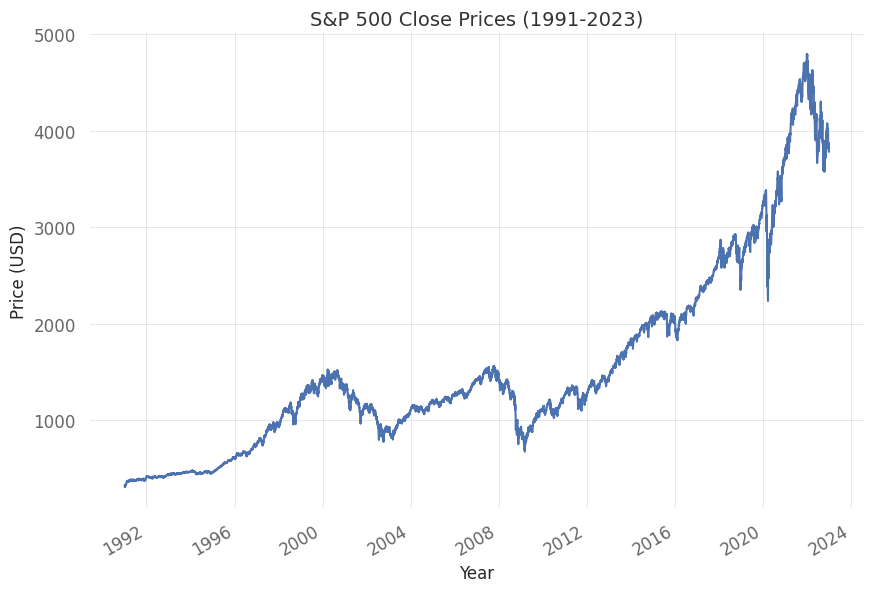

In [4]:
# Plotting the S&P 500 closing prices
close_prices.plot(figsize=(10, 7), linewidth=1.5)
plt.title('S&P 500 Close Prices (1991-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True)
plt.show()

##### Key Features of the Plot:

* Figure Size: figsize=(10, 7) sets an appropriate size for the plot, ensuring clarity and readability.
* Styling: The color and linewidth enhance the visual appeal and emphasis on the plot line.
* Title and Labels: Descriptive title and axis labels are added for better comprehension. Font sizes are adjusted for better visibility.
* Gridlines: Gridlines are enabled to aid in reading off specific values from the chart.

---
## Step 1: Developing Robust Indicators

### The Foundation of Trading Signals: Understanding Indicators
In the architecture of algorithmic trading, the role of an 'indicator' is foundational. Indicators serve as the building blocks or raw inputs from which trading signals are constructed. They provide essential data or insights, which, when processed and analyzed, contribute to the formation of predictive trading signals.

#### Exploring the Diversity of Indicators:
* **Broad Spectrum of Sources**: Indicators can originate from a wide array of sources. While they often include technical metrics, their scope extends far beyond. For example:
    * **Technical Indicators**: These are derived from statistical calculations based on historical trading data, such as price and volume. Common examples include the Relative Strength Index (RSI), Moving Averages, or Bollinger Bands. We recommend to limit use of these indicators. There are 2 sources here that are known to work: momentum and short term reversals.

    * **Alternative Indicators**: These encompass a range of data points from various fields. A quintessential example would be weather data used in energy market trading. For instance, extremely cold temperatures might increase the demand for heating, thereby impacting energy prices. Quant traders will construct signals based on indicators created from alternative data sources, such as NLP applied to twitter data, or satellite images of cars in a wallmart parking.

#### Characteristics of Indicators:
* Descriptive, Not Predictive: It’s important to distinguish that, in isolation, indicators typically lack direct predictive power. They are descriptive metrics that represent current or historical states or trends.

* The Raw Material for Signals: Think of indicators as the raw material that, when refined through analysis and combined with other data, transforms into a signal. This transformation often involves integrating multiple indicators, applying statistical methods, or feeding them into machine learning models to distill actionable insights.

#### Crafting Effective Indicators:
* **Relevance and Accuracy**: The effectiveness of an indicator lies in its relevance to the market being analyzed and the accuracy of the data it represents. Irrelevant or inaccurate indicators can lead to misleading signals.
* **Diverse Data for Robustness**: Employing a variety of indicators, ranging from market data to economic factors, enhances the robustness of your trading strategy. This diversity can help capture different aspects of market dynamics, leading to more comprehensive and reliable signals.

Developing indicators is a crucial step in the process of creating reliable trading signals. While they are not predictive in themselves, their role in providing critical information and insights cannot be understated. The art lies in selecting the right indicators, interpreting them correctly, and skillfully integrating them into a cohesive strategy that informs profitable trading decisions.

### Our example:
#### Moving Average Crossover Strategy Logic
The strategy involves two moving averages (indicators):
- A short-term moving average (e.g., 50 days)
- A long-term moving average (e.g., 200 days)

We generate a buy signal when the short-term moving average crosses above the long-term moving average and a sell signal when it crosses below. This is just a toy exampe to illustrate how to run a backtest - don't use this in real life!

In [5]:
# Calculating Moving Averages (Indicators)
short_window = 50
long_window = 252

short_ma = close_prices.rolling(window=short_window, min_periods=short_window).mean()
long_ma = close_prices.rolling(window=long_window, min_periods=long_window).mean()

In [6]:
short_ma

Date
1991-01-02            NaN
1991-01-03            NaN
1991-01-04            NaN
1991-01-07            NaN
1991-01-08            NaN
                 ...     
2022-12-23    3885.761816
2022-12-27    3890.685415
2022-12-28    3892.790815
2022-12-29    3895.376816
2022-12-30    3898.263618
Name: Close, Length: 8062, dtype: float64

In [7]:
long_ma

Date
1991-01-02            NaN
1991-01-03            NaN
1991-01-04            NaN
1991-01-07            NaN
1991-01-08            NaN
                 ...     
2022-12-23    4116.434373
2022-12-27    4112.617151
2022-12-28    4108.636476
2022-12-29    4104.891317
2022-12-30    4101.164214
Name: Close, Length: 8062, dtype: float64

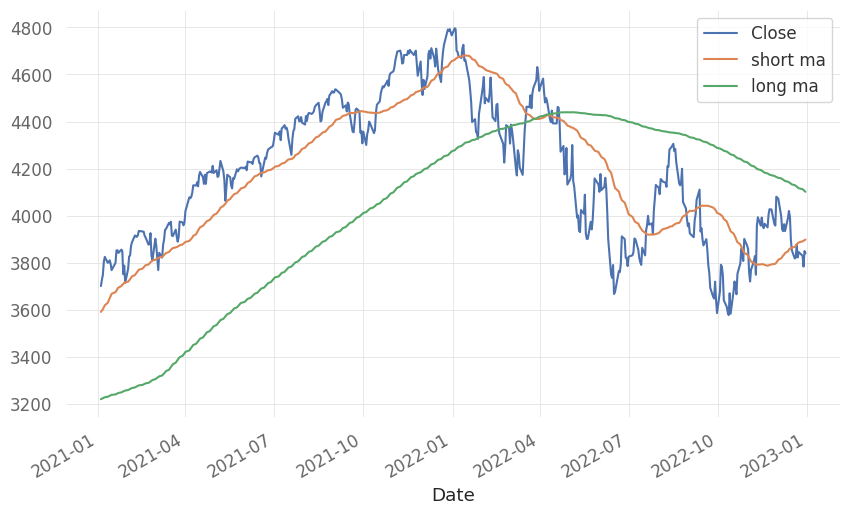

In [13]:
dt = '2021-01-01'
close_prices[dt:].plot()
short_ma[dt:].plot(label="short ma")
long_ma[dt:].plot(label="long ma")
plt.legend()

## Step 2: Crafting Effective Trading Signals
In the realm of algorithmic trading, the concept of a 'signal' is pivotal and distinct from mere 'indicators'. A trading signal is essentially a prognostic tool, possessing predictive power about future market movements. Unlike indicators, which primarily describe current or past market conditions, signals provide actionable insights for future trades.

### Understanding the Nature of Signals:
* Predictive Strength: Signals range from -1 to 1, representing the confidence level of a prediction. The closer a signal is to the extremities (-1 or 1), the higher the confidence in the forecast.

Interpreting Signal Values:
* **Negative Values (-1 to -0.001)**: Indicate a bearish outlook, suggesting a potential decrease in the asset's value. In practical terms, this range implies taking a 'short' position.
* **Positive Values (0.001 to 1)**: Suggest a bullish outlook, pointing towards an anticipated increase in the asset's value. Here, the strategy would lean towards a 'long' position.
* **Values Around 0**: Signal a state of uncertainty or neutrality in the model's prediction. A signal close to 0 implies that the model lacks enough conviction to suggest a clear market direction.

### Practical Tip for Signal Generation:
* Leveraging the TanH Function: In machine learning models, employing the hyperbolic tangent (TanH) function is a common practice to normalize output signals to the range of [-1, 1]. This normalization helps in standardizing the prediction output, making it interpretable in the context of trading signals.

Additionally, this technique isn't confined to machine learning. It can be equally effective in conventional trading algorithms for transforming raw prediction values into standardized trading signals.

### The Role of Signals in Trade Decision Making:
It's crucial to understand that while signals guide the direction of the trade (long or short), they don't dictate the position size or the risk management strategy. The strength of the signal should be used in conjunction with other factors, such as portfolio balance, risk tolerance, and market conditions, to make informed trading decisions.

In essence, a well-constructed signal provides a clear directional bias for trading, but it's just one piece of the puzzle in the broader strategy of trade execution and risk management. Integrating signals with a robust trading system ensures that both market forecasts and risk are optimally balanced.

## Our example
Our signal is just a simple buy or sell, -1 or 1. If we have positive momentum then buy, else sell.

* Note that we will use the raw signal as the weight of the position. 

In [14]:
# Generating Trading Signals
signals = pd.DataFrame(index=close_prices.index)
signals['signal'] = 0.0  # Set the default to be 0
signals['short_ma'] = short_ma
signals['long_ma'] = long_ma

# When the short is above the long, buy - else go short sell.
# Note that our signal is just a simple buy or sell, -1 or 1.
signals['signal'][signals['short_ma'] > signals['long_ma']] = 1
signals['signal'][signals['short_ma'] < signals['long_ma']] = -1

In [15]:
signals

,signal,short_ma,long_ma
Date,,,
1991-01-02,0.0,NaN,NaN
1991-01-03,0.0,NaN,NaN
1991-01-04,0.0,NaN,NaN
1991-01-07,0.0,NaN,NaN
1991-01-08,0.0,NaN,NaN
...,...,...,...
2022-12-23,-1.0,3885.761816,4116.434373
2022-12-27,-1.0,3890.685415,4112.617151
2022-12-28,-1.0,3892.790815,4108.636476


## Step 3: Calculating Daily Returns for the Strategy

Proper calculation of returns is essential for evaluating the performance of any trading strategy. In our approach, we take special care to account for look-ahead bias, a common pitfall in strategy development.

Addressing Look-Ahead Bias:
* **Look-Ahead Bias**: This occurs when a strategy uses information that would not have been available at the time of trading. To avoid this, we lag our signals by one day. This adjustment ensures that our strategy only uses information that would have been available at the market close of the previous day.

### Implementation: Computing Strategy Returns

1. **Calculating Base Market Returns**: First, we compute the daily returns of the S&P 500 index (or spx). Daily returns are calculated based on the percentage change in closing prices from one day to the next.

In [16]:
# Calculate daily percentage returns of SPX
spx_returns = close_prices.pct_change()

In [17]:
spx_returns.tail()

Date
2022-12-23    0.005868
2022-12-27   -0.004050
2022-12-28   -0.012021
2022-12-29    0.017461
2022-12-30   -0.002541
Name: Close, dtype: float64

In [18]:
spx_returns.head()

Date
1991-01-02         NaN
1991-01-03   -0.013907
1991-01-04   -0.002827
1991-01-07   -0.017321
1991-01-08   -0.001712
Name: Close, dtype: float64

2. **Applying the Strategy**: Next, we apply our trading signals to these returns. The signal is shifted by one day (shift(1)) to avoid look-ahead bias. This means that the trading decision for a given day is based on the signal from the previous day.

In [22]:
# Calculate strategy returns by multiplying SPX returns with the lagged signals
strategy_returns = spx_returns * signals['signal'].shift(1)

print(f"{strategy_returns.tail()=}")
print(f"{spx_returns.tail()=}")
print(f"{signals['signal'].shift(1).tail()=}")

strategy_returns.tail()=Date
2022-12-23   -0.005868
2022-12-27    0.004050
2022-12-28    0.012021
2022-12-29   -0.017461
2022-12-30    0.002541
dtype: float64
spx_returns.tail()=Date
2022-12-23    0.005868
2022-12-27   -0.004050
2022-12-28   -0.012021
2022-12-29    0.017461
2022-12-30   -0.002541
Name: Close, dtype: float64
signals['signal'].shift(1).tail()=Date
2022-12-23   -1.0
2022-12-27   -1.0
2022-12-28   -1.0
2022-12-29   -1.0
2022-12-30   -1.0
Name: signal, dtype: float64


#### Explanation:
* Multiplying Returns by Signals: The `strategy_returns` are the product of the `spx_returns` and the lagged signals. Here, a positive signal indicates a long position, and a negative signal indicates a short position. A zero signal implies no position, resulting in zero returns for that day.

* Lagged Signals: By using `shift(1)`, we ensure that the trading decision for any given day is based solely on information available up to the end of the previous day, thereby realistically simulating a trading scenario and maintaining the integrity of our backtest.

By accurately computing the strategy's daily returns and conscientiously addressing look-ahead bias, we lay a solid foundation for a realistic and reliable evaluation of the strategy's performance. This methodological rigor is crucial for developing strategies that not only perform well historically but also hold up in live trading scenarios.

## Step 4: Position Sizing

Position sizing is a critical aspect of trading strategy that can significantly impact the risk and return profile of an investment portfolio.

### Exploring Position Sizing Techniques
* **Field of Study**: Position sizing is an extensive field of study under portfolio construction. It involves determining the appropriate amount of capital to allocate to each investment, balancing risk and potential returns.

* **Recommended Learning Paths**:

    * **Mean-Variance Portfolio Construction**: This foundational concept in modern portfolio theory helps in optimizing the allocation of weights to different assets, based on their expected returns, risks (variance), and correlations.
    * **Meta-Labeling**: An advanced technique that integrates machine learning. Meta-labeling not only decides the direction of trades (long or short) but also helps in determining the size of positions, based on the probability of a successful prediction.
    
For this course, we show you how to backtest a strategy where you forecast a single asset, for this we recommend learning more about volatility targeting, and the Kelly Criterion. There are lectures and papers covered in this course.

### Implementing Volatility-Targeted Position Sizing
##### Computing Volatility-Targeted Weights
We aim to implement a strategy where each position is sized according to a target volatility level. This approach helps in standardizing risk across different trades.

<AxesSubplot:xlabel='Date'>

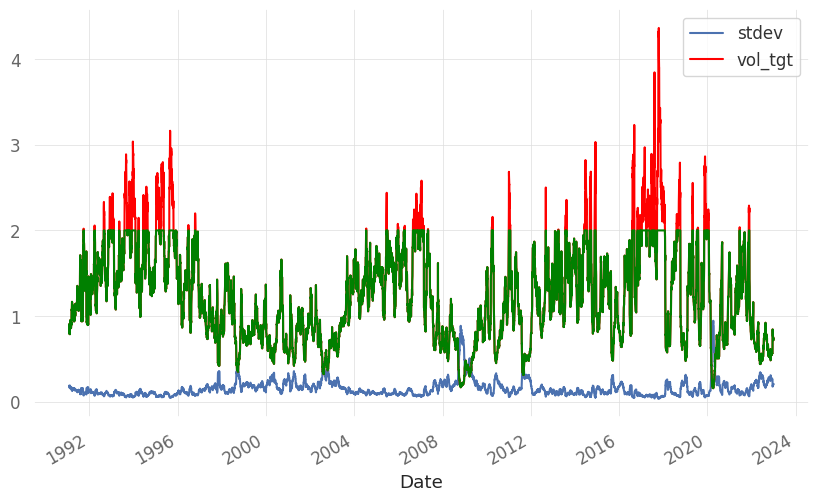

In [32]:
# Set the target volatility level
tgt_vol = 0.15

# Calculate the rolling annual standard deviation of SPX returns
signals['stdev'] = spx_returns.rolling(22).std() * np.sqrt(252)  # Convert to annualized standard deviation

# Calculate volatility target weights
signals['vol_tgt'] = tgt_vol / signals['stdev']

signals['stdev'].plot()
signals['vol_tgt'].plot(color="red")
plt.legend()

# Clip weights to a maximum of 1 to avoid leverage
# Here we use 2x leverage to make sure we can hit our volatility target of 15%
signals['vol_tgt'] = signals['vol_tgt'].clip(0, 2)
signals["vol_tgt"].plot(color="green")

`vol_tgt` is our position size

when `stdev` is close to target vol then our position is close to 100% of portfolio 

##### Calculating Strategy Returns with Volatility Targeting
We then apply these volatility-targeted weights to our strategy, adjusting the signal strength based on the desired level of risk exposure.

In [35]:
signals['vol_tgt'].tail(10)

Date
2022-12-16    0.769816
2022-12-19    0.768520
2022-12-20    0.768064
2022-12-21    0.742584
2022-12-22    0.724786
2022-12-23    0.743173
2022-12-27    0.749625
2022-12-28    0.740126
2022-12-29    0.719612
2022-12-30    0.719462
Name: vol_tgt, dtype: float64

In [37]:
signals['vol_tgt'].shift(1).tail(9)

Date
2022-12-19    0.769816
2022-12-20    0.768520
2022-12-21    0.768064
2022-12-22    0.742584
2022-12-23    0.724786
2022-12-27    0.743173
2022-12-28    0.749625
2022-12-29    0.740126
2022-12-30    0.719612
Name: vol_tgt, dtype: float64

In [38]:
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['vol_tgt'].shift(1)

# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = spx_returns * vol_signal

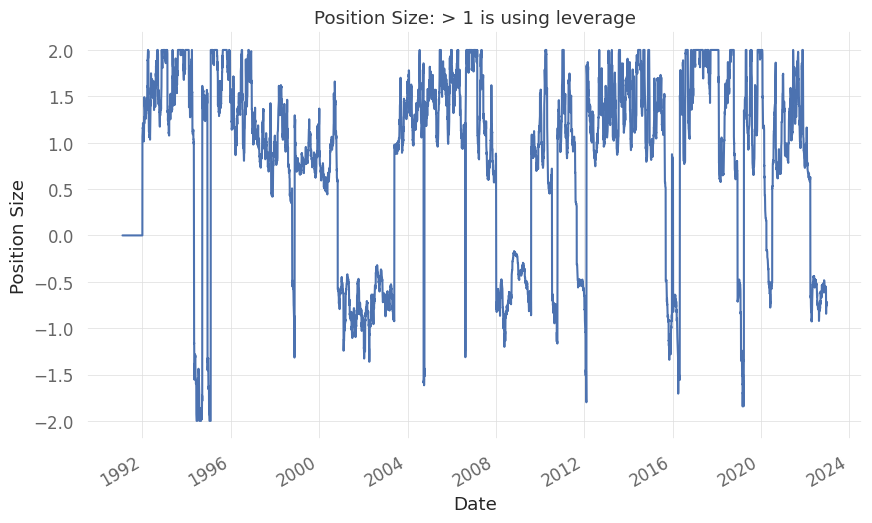

In [39]:
# Plot the position sizes to see how much leverage is being used.
vol_signal.plot()
plt.title('Position Size: > 1 is using leverage')
plt.ylabel('Position Size')
plt.show()

#### Key Takeaways
* **Risk Standardization**: Volatility-targeted position sizing helps in standardizing risk across different positions, aligning each trade with the overall risk tolerance of the portfolio.
* **Dynamic Adjustment**: This approach dynamically adjusts position sizes based on changing market volatility, contributing to more effective risk management.
* **Limiting Leverage**: By clipping the maximum weight to 1, the strategy avoids the use of leverage, sticking to a more conservative investment approach.

Mastering position sizing is crucial for the successful implementation of a trading strategy. By aligning each position with a predefined risk parameter, traders can achieve a more balanced and risk-aware portfolio. The techniques of mean-variance optimization and meta-labeling, along with practical implementations like volatility targeting, provide a solid foundation for effective portfolio management.

---
## Comprehensive Performance Analysis with QuantStats

Next we utilize the powerful capabilities of QuantStats to conduct a thorough performance analysis. Our objective is to compare and contrast the results of two distinct strategies: the baseline strategy (which serves as our benchmark) and the strategy incorporating volatility-targeted weights.

QuantStats is a Python library specifically designed for the performance analysis of financial portfolios and trading strategies. It provides a suite of tools for generating comprehensive reports, known as performance tearsheets, that offer in-depth insights into the strategy's effectiveness.

To execute this comparative analysis, we will utilize QuantStats' full report functionality. This method generates a detailed report that encompasses various performance metrics and visualizations, offering a holistic view of the strategy's performance.

### Plotting the Results:
Here's how we implement the QuantStats report in our notebook:

##### Parameters Explained:
* `returns`: The strategy_voltgt_returns represents the returns of our strategy that applies volatility-targeted weights.
* `benchmark`: The strategy_returns acts as the baseline for comparison. It represents the returns of our basic strategy without volatility adjustments.
* `output`: Specifies the output format of the report. Here, 'report.html' indicates that the report will be generated as an HTML file.
* `title`: Gives a title to the report. In this case, 'Volatility Targeted Strategy vs. Basic Strategy' succinctly describes the comparative nature of the analysis.

CAGR - Compound Annual Growth Rate

Sortio focuses only on downside deviations below (in this case) 0 (risk free rate)

In [41]:
help(qs.stats)

Help on module quantstats.stats in quantstats:

NAME
    quantstats.stats

DESCRIPTION
    # -*- coding: UTF-8 -*-
    #
    # QuantStats: Portfolio analytics for quants
    # https://github.com/ranaroussi/quantstats
    #
    # Copyright 2019-2023 Ran Aroussi
    #
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.

FUNCTIONS
    adjusted_sortino(returns, rf=0, periods=252, annualize=True, smart=False)
        Jack Schwager's version of the Sortino ratio all

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               1991-12-31   1991-12-31
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          426.4%       859.68%
CAGR﹪                     3.77%        5.16%

Sharpe                     0.38         0.53
Prob. Sharpe Ratio         98.3%        99.84%
Smart Sharpe               0.37         0.52
Sortino                    0.54         0.74
Smart Sortino              0.52         0.72
Sortino/√2                 0.38         0.52
Smart Sortino/√2           0.37         0.51
Omega                      1.09         1.09

Max Drawdown               -47.5%       -34.35%
Longest DD Days            5044         1299
Volatility (ann.)          18.49%       16.1%
R^2                        0.73         0.73
Information Ratio          0.01         0.01
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,1994-02-03,1995-02-02,1995-11-15,651,-34.353435,-33.458928
2,2014-12-08,2016-11-04,2017-10-04,1032,-29.469251,-27.697499
3,2010-04-26,2012-06-01,2013-11-14,1299,-28.970334,-26.826474
4,2018-09-21,2020-06-08,2021-07-01,1015,-27.014202,-25.513645
5,1998-07-20,1998-12-14,2001-08-29,1137,-25.647911,-24.228864


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


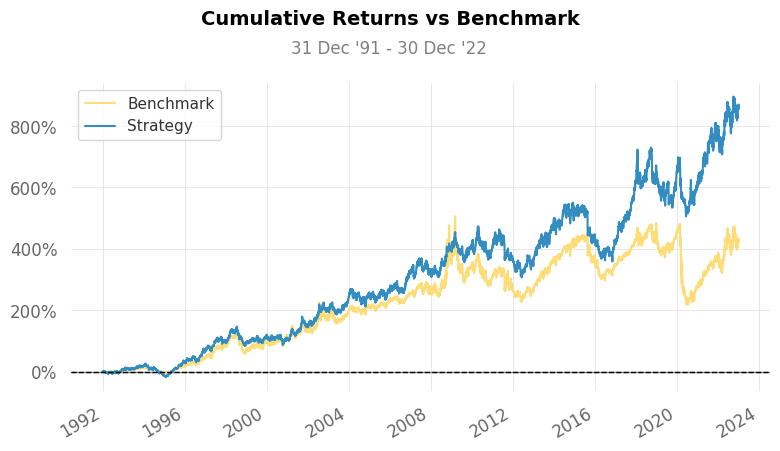

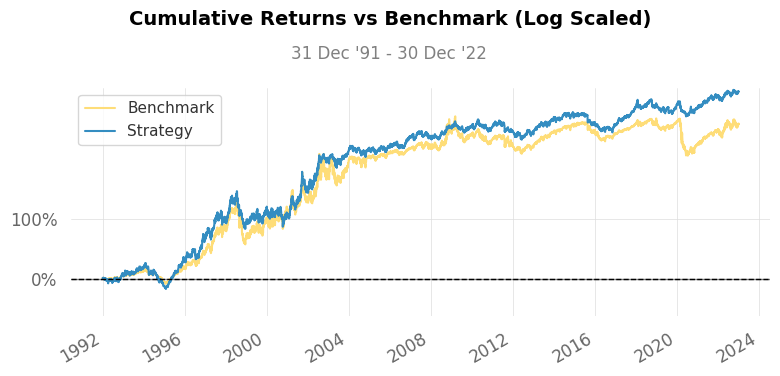

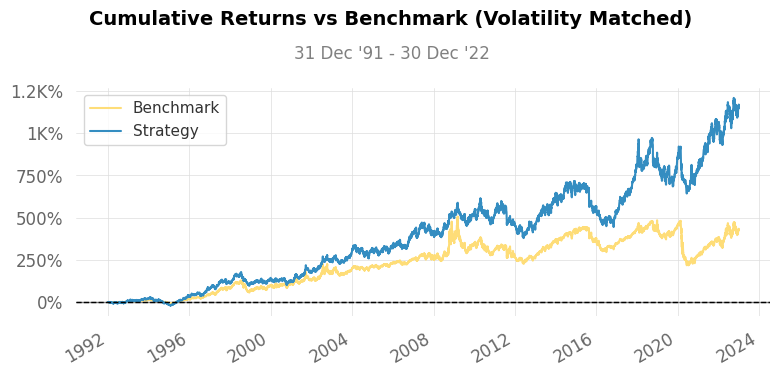

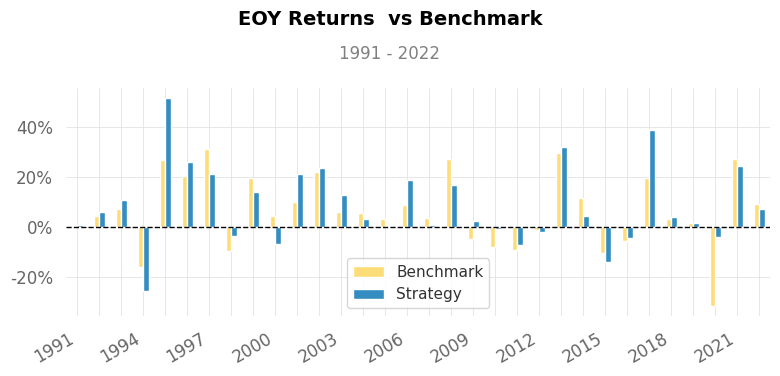

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


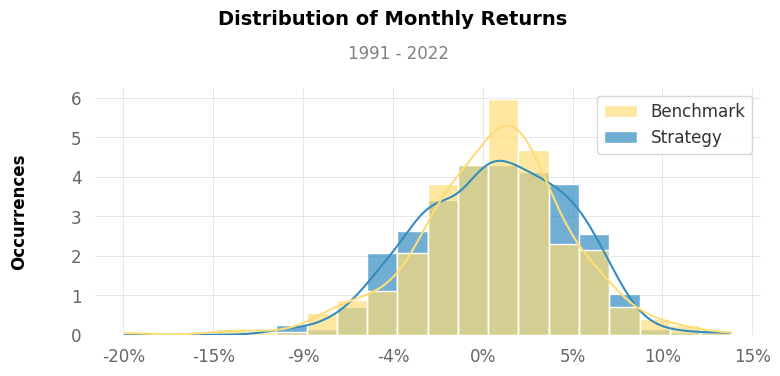

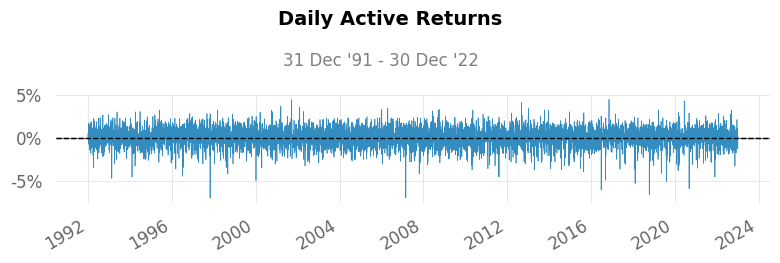

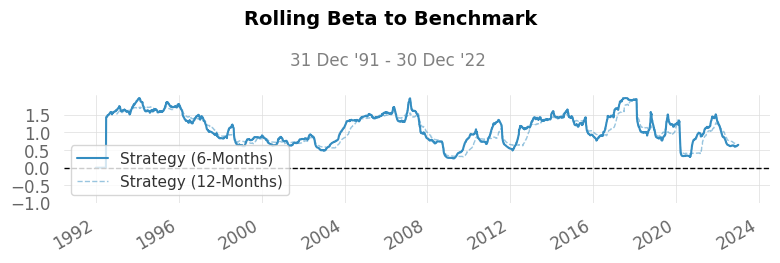

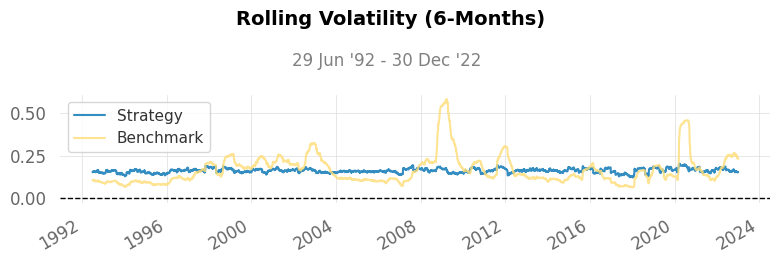

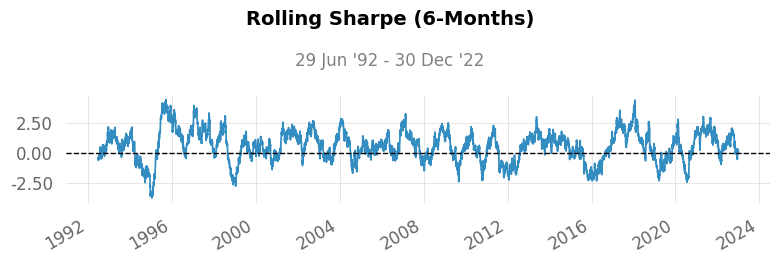

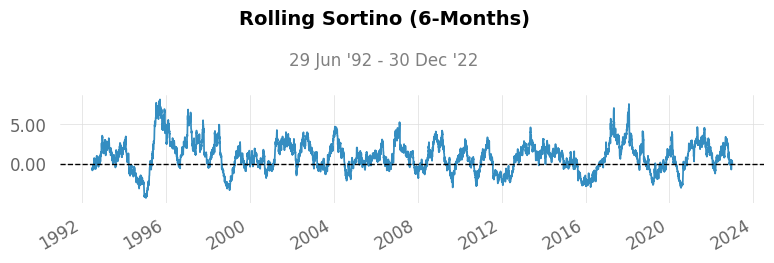

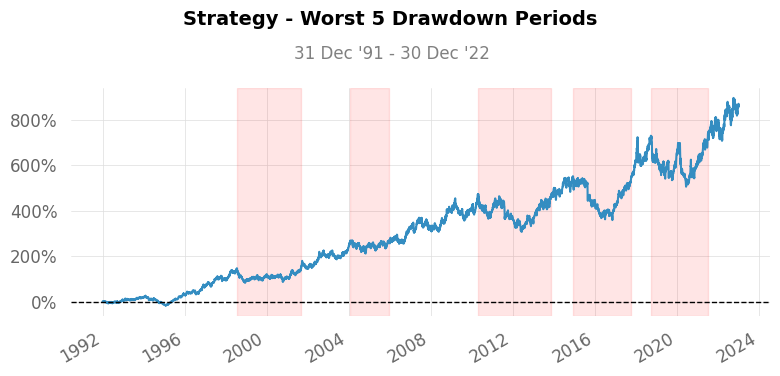

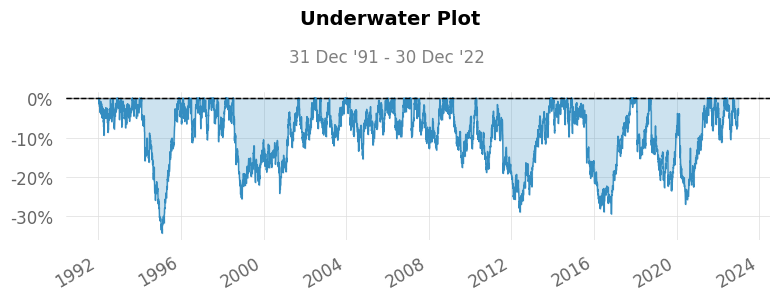

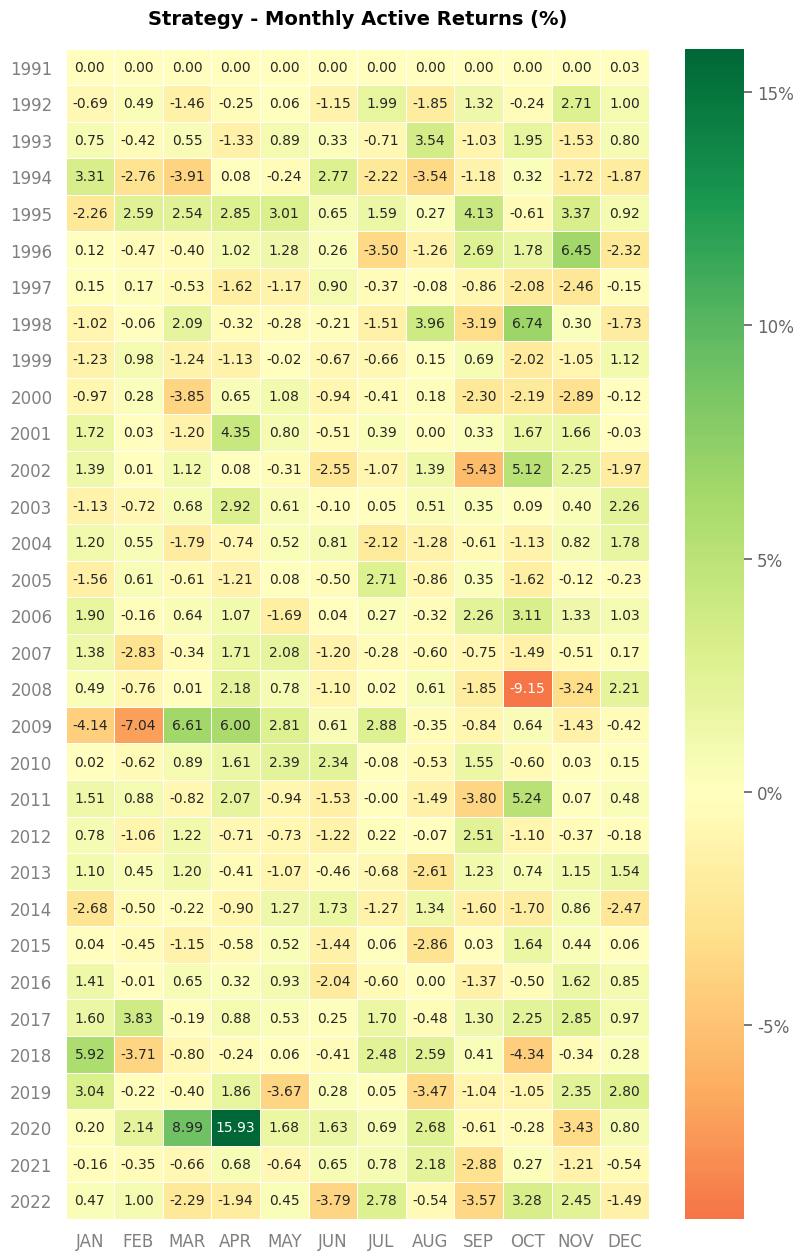

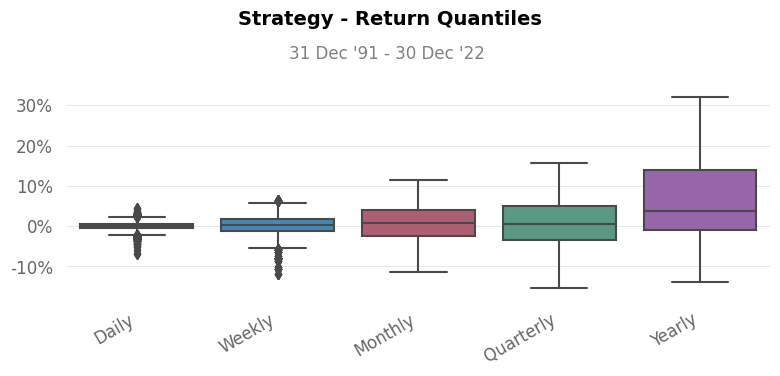

In [40]:
qs.reports.full(returns=strategy_voltgt_returns, 
                benchmark=strategy_returns,
                output='report.html', 
                title='Volatility Targeted Strategy vs. Basic Strategy')

## Troubleshooting

From some experiments that I ran, it looks like QuantStats is having problems with the latest version of the plotting libraries. This is a common problem with python libraries. 

I noted that in the monthly active returns plot, those values don't look correct. The rest looks pretty good. 

# Conclusion
The integration of QuantStats into our analysis workflow empowers us to conduct a nuanced and comprehensive evaluation of our trading strategies. This step is crucial in understanding the real-world applicability of our theoretical constructs and in making informed decisions to refine and optimize our trading approaches.

* In this tutorial, we successfully implemented and backtested a moving average crossover strategy on SPX close price data. 
* We added a volatility-Targeted weighting scheme.
* The QuantStats library provided comprehensive performance metrics for our strategy.
